In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


In [ ]:
from fitter import Fitter

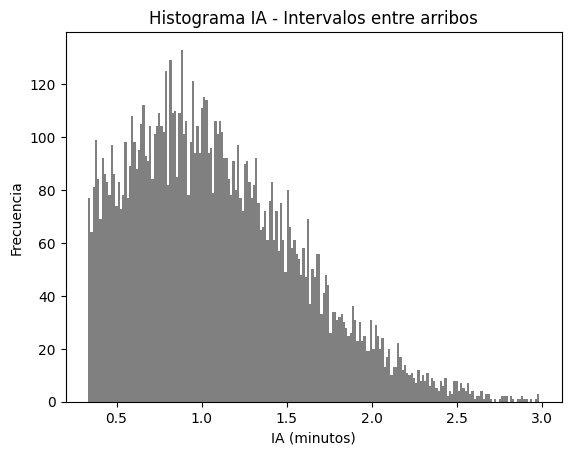

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Está puesto en MyDrive/NombreDeArchivo porque a los que no somos dueños de esta carpeta, tira error.
recital = pd.read_csv("/content/drive/MyDrive/Grupo5-Festival_barras.csv")
recital['arrival_timestamp'] = pd.to_datetime(recital['arrival_time'])

# Ordenar por timestamp antes de calcular la diferencia
recital = recital.sort_values('arrival_timestamp').copy()

# Extraer la fecha para agrupar
recital['fecha'] = recital['arrival_timestamp'].dt.date

# Calcular el intervalo de arribos por día
recital['interarrival_time'] = recital.groupby('fecha')['arrival_timestamp'].diff().dt.total_seconds() / 60 # en minutos

# Eliminar valores NaN generados por el diff (la primera llegada de cada día)
recital = recital.dropna(subset=['interarrival_time']).copy()

# Eliminar valores anómalos (outliers) por encima de 0.35 minutos
recital_filtrado = recital[recital['interarrival_time'] < 3].copy()


# Histograma
plt.hist(recital_filtrado['interarrival_time'].dropna(), bins=200, color="grey")
plt.xlabel("IA (minutos)")
plt.ylabel("Frecuencia")
plt.title("Histograma IA - Intervalos entre arribos")
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
geninvgauss,0.767976,322.778693,351.613249,0.023572,0.034415,1.042993e-10


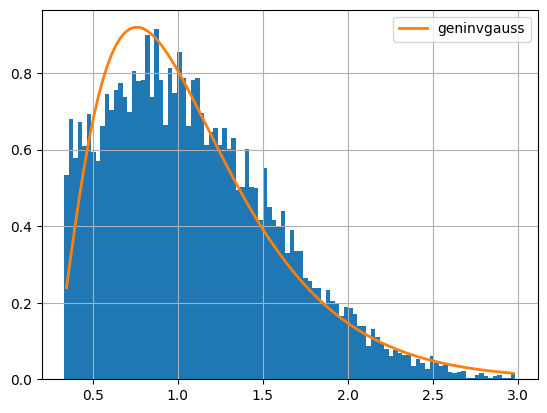

In [ ]:
# Instalar lo de abajo si tira BrokenProcessPool
# pip install --upgrade numpy

# Filtramos valores nulos
interarrivals = recital_filtrado["interarrival_time"].dropna()

f_inter = Fitter(interarrivals,
                 distributions=['geninvgauss'],
                 timeout=100)

# Usar fit sin parámetros adicionales
f_inter.fit()
f_inter.summary(10)

In [ ]:
# Obtengo los parámetros de la mejor fdp
f_inter.get_best(method='sumsquare_error')

{'geninvgauss': {'p': np.float64(2.4994524012730244),
  'b': np.float64(8.516130339347142e-05),
  'loc': np.float64(0.2564883133308904),
  'scale': np.float64(1.4272374902362608e-05)}}

In [ ]:
# Filtrar tiempos de servicio
cervezas_df = recital[recital["drink"] == "Cerveza"]
cocteles_df = recital[recital["drink"] != "Cerveza"]

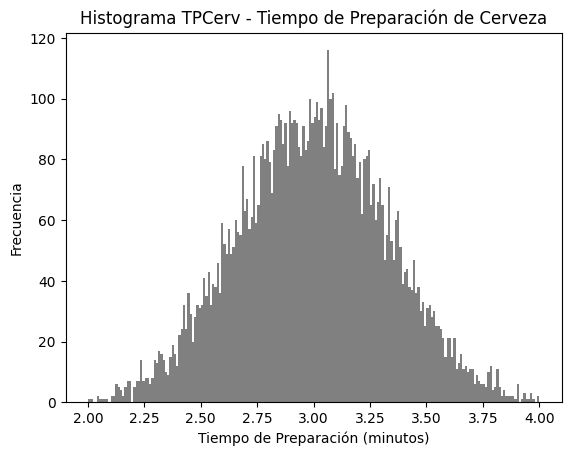

In [ ]:
# Histograma cervezas
cervezas_df['service_time_minutes'] = cervezas_df['service_time'] / 60

cervezas_df_filtered = cervezas_df[cervezas_df["service_time_minutes"] < 350/60].copy()

plt.hist(cervezas_df_filtered["service_time_minutes"].dropna(), bins=200,color="grey")
plt.xlabel("Tiempo de Preparación (minutos)")
plt.ylabel("Frecuencia")
plt.title("Histograma TPCerv - Tiempo de Preparación de Cerveza")
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,0.262703,283.151885,311.085143,inf,0.005871,0.944867


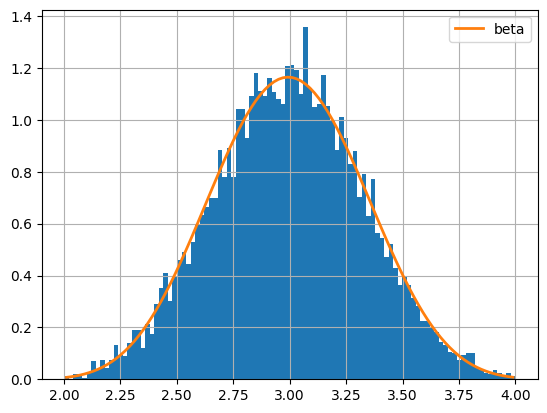

In [32]:
service_cerveza = cervezas_df["service_time_minutes"].dropna()

f_cer = Fitter(service_cerveza,distributions=['beta'])
f_cer.fit()
f_cer.summary(10)

In [ ]:
# Obtengo los parámetros de la mejor fdp
f_cer.get_best(method='sumsquare_error')

{'beta': {'a': np.float64(9.734076547834276),
  'b': np.float64(10.07150567720017),
  'loc': np.float64(1.5165460447127541),
  'scale': np.float64(3.010872601399507)}}

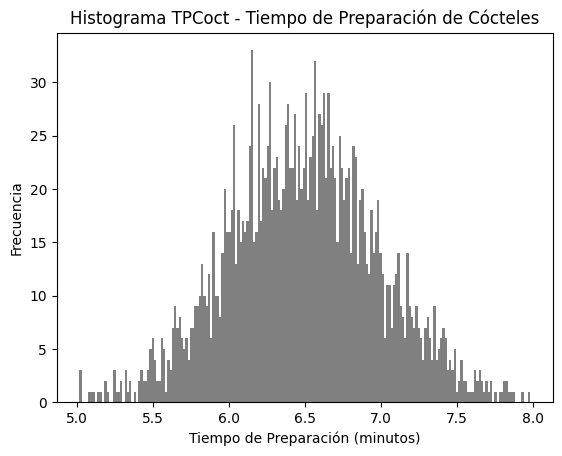

In [ ]:
# Histograma cocteles
cocteles_df['service_time_minutes'] = cocteles_df['service_time'] / 60

cocteles_df_filtered = cocteles_df[(cocteles_df["service_time_minutes"] >= 6/60) & (cocteles_df["service_time_minutes"] <= 1500/60)].copy() # Convert filter values to minutes

plt.hist(cocteles_df_filtered["service_time_minutes"].dropna(), bins=200, color='grey')
plt.xlabel("Tiempo de Preparación (minutos)")
plt.ylabel("Frecuencia")
plt.title("Histograma TPCoct - Tiempo de Preparación de Cócteles")
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
johnsonsb,0.273268,353.741717,376.191064,inf,0.01081,0.970077


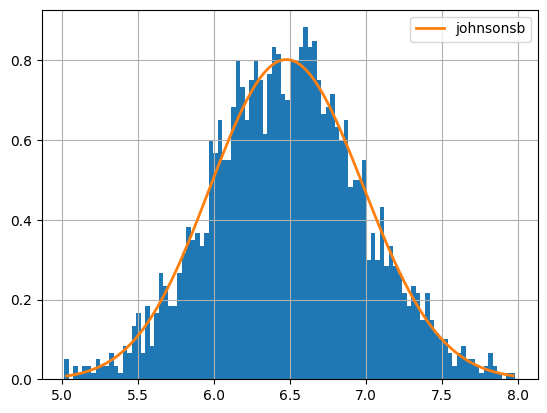

In [ ]:
service_coctel = cocteles_df["service_time_minutes"].dropna()

f_coctel = Fitter(service_coctel,distributions=['johnsonsb'])
f_coctel.fit()
f_coctel.summary(10)

In [ ]:
# Obtengo los parámetros de la mejor fdp
f_coctel.get_best(method='sumsquare_error')

{'johnsonsb': {'a': np.float64(0.6306422784821466),
  'b': np.float64(4.97166150631833),
  'loc': np.float64(1.8339643758688478),
  'scale': np.float64(9.931314077243272)}}

In [33]:
#v34 - CORREGIDO SEGÚN DOCUMENTO GRUPO 5
# SIMULACIÓN SISTEMA DE BARRAS DEL FESTIVAL CON DISTRIBUCIONES REALES
# ==================================================================

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import heapq
import warnings
from scipy.stats import geninvgauss, beta, johnsonsb
warnings.filterwarnings('ignore')

# Establecer semillas para reproducibilidad
np.random.seed(42)
random.seed(42)

class FestivalBarSimulationReales:
    """
    Simulación CORREGIDA según documento Grupo 5
    """

    def __init__(self, n_cerveceros, n_cocteleros, umbral_redireccion, tiempo_final=500):
        # Parámetros de la simulación
        self.BCE = n_cerveceros
        self.BCO = n_cocteleros
        self.UR = umbral_redireccion
        self.TF = tiempo_final

        # Variables de estado (según documento)
        self.tiempo_actual = 0
        self.cola_cerveza = []  # NSCerv = len(self.cola_cerveza) + cerveceros ocupados
        self.cola_coctel = []   # NSCoct = len(self.cola_coctel) + cocteleros ocupados

        # Trackear clientes siendo atendidos
        self.clientes_en_servicio_cerveza = 0
        self.clientes_en_servicio_coctel = 0

        # Estado de bartenders (tiempo cuando terminarán de servir)
        self.bartenders_cerveza = [0] * n_cerveceros
        self.bartenders_coctel = [0] * n_cocteleros

        # Contadores y estadísticas
        self.total_cerveceros = 0
        self.total_cocteleros = 0
        self.abandonos_cerveza = 0
        self.abandonos_coctel = 0

        # Tiempos para estadísticas
        self.tiempo_espera_cerveza = []
        self.tiempo_espera_coctel = []
        self.tiempo_ocioso_cerveza = [0] * n_cerveceros
        self.tiempo_ocioso_coctel = [0] * n_cocteleros
        self.ultimo_tiempo_ocupado_cerveza = [0] * n_cerveceros
        self.ultimo_tiempo_ocupado_coctel = [0] * n_cocteleros

        # Lista de eventos
        self.eventos = []
        self.contador_clientes = 0

        # Programar primera llegada
        primera_llegada = self.tiempo_actual + self.generar_intervalo_arribo() # Changed to self.tiempo_actual
        heapq.heappush(self.eventos, (primera_llegada, 'llegada', None))

    def NSCerv(self):
        """Número de Cerveceros en el Sistema"""
        return len(self.cola_cerveza) + self.clientes_en_servicio_cerveza

    def NSCoct(self):
        """Número de Cocteleros en el Sistema"""
        return len(self.cola_coctel) + self.clientes_en_servicio_coctel

    def hay_coctelero_libre(self):
        """Verifica si hay bartender de cóctel inactivo (según documento)"""
        return any(tiempo <= self.tiempo_actual for tiempo in self.bartenders_coctel)

    def generar_intervalo_arribo(self):
        """Genera intervalo entre arribos usando distribución GENINVGAUSS real"""
        try:
            # Using the fitted parameters from the previous cell if available
            best_params = f_inter.get_best(method='sumsquare_error')['geninvgauss']
            p = best_params['p']
            b = best_params['b']
            loc = best_params['loc']
            scale = best_params['scale']
            valor = geninvgauss.rvs(p, b, loc=loc, scale=scale)
            return max(0.1, valor)  # evitar valores 0 o negativos
        except Exception as e:
            print(f"Error generando intervalo usando fitted params: {e}. Falling back to exponential.")
            return np.random.exponential(1.0)

    def generar_tiempo_servicio_cerveza(self):
        """Genera tiempo de servicio para cerveza usando distribución BETA real"""
        try:
            # Using the fitted parameters from the previous cell if available
            best_params = f_cer.get_best(method='sumsquare_error')['beta']
            a = best_params['a']
            b = best_params['b']
            loc = best_params['loc']
            scale = best_params['scale']
            valor = beta.rvs(a, b, loc=loc, scale=scale)
            return max(0.5, valor)
        except Exception as e:
            print(f"Error generando tiempo cerveza usando fitted params: {e}. Falling back to uniform.")
            return np.random.uniform(1, 3)

    def generar_tiempo_servicio_coctel(self):
        """Genera tiempo de servicio para cóctel usando distribución JOHNSONSB real"""
        try:
            # Using the fitted parameters from the previous cell if available
            best_params = f_coctel.get_best(method='sumsquare_error')['johnsonsb']
            a = best_params['a']
            b = best_params['b']
            loc = best_params['loc']
            scale = best_params['scale']
            valor = johnsonsb.rvs(a, b, loc=loc, scale=scale)
            return max(1.0, valor)
        except Exception as e:
            print(f"Error generando tiempo coctel usando fitted params: {e}. Falling back to uniform.")
            return np.random.uniform(3, 7)

    def determinar_tipo_cliente(self):
        """Determina tipo de cliente: 80% cerveza, 20% cóctel"""
        return 'cerveza' if random.random() < 0.8 else 'coctel'

    def verificar_abandono(self, tipo_cliente, tamaño_cola):
        """
        CORREGIDO según documento página 1:
        - Cerveza: 30% si >= 10 en cola, 50% si >= 12 en cola
        - Cóctel: 40% si >= 5 en cola, 100% si >= 7 en cola
        """
        r = random.random()

        if tipo_cliente == 'coctel':
            if tamaño_cola >= 7:
                return True  # 100% abandono
            elif tamaño_cola >= 5:
                return r < 0.40  # 40% abandono
        else:  # cerveza
            if tamaño_cola >= 12:
                return r < 0.50  # 50% abandono
            elif tamaño_cola >= 10:
                return r < 0.30  # 30% abandono

        return False

    def encontrar_bartender_libre(self, tipo):
        """Encuentra el bartender que estará libre más pronto"""
        if tipo == 'cerveza':
            bartenders = self.bartenders_cerveza
        else:
            bartenders = self.bartenders_coctel

        min_tiempo = min(bartenders)
        indice = bartenders.index(min_tiempo)
        return indice, min_tiempo

    def redirigir_cliente_cerveza(self):
        """Redirige al cliente en posición UR de la cola de cerveza (según documento)"""
        if len(self.cola_cerveza) >= self.UR and self.hay_coctelero_libre() and len(self.cola_coctel) == 0:
            # Tomar cliente en posición UR (índice UR-1 ya que la lista empieza en 0)
            cliente_idx = self.UR - 1
            if cliente_idx < len(self.cola_cerveza):
                cliente = self.cola_cerveza.pop(cliente_idx)
                cliente_id, tiempo_llegada, _ = cliente

                # Atender con coctelero libre
                indice_coctel, tiempo_libre = self.encontrar_bartender_libre('coctel')
                tiempo_servicio = self.generar_tiempo_servicio_cerveza()
                tiempo_finalizacion = self.tiempo_actual + tiempo_servicio

                self.bartenders_coctel[indice_coctel] = tiempo_finalizacion
                heapq.heappush(self.eventos, (tiempo_finalizacion, 'salida_cerveza_por_coctelero',
                                             (cliente_id, indice_coctel, tiempo_llegada)))
                return True
        return False

    def procesar_llegada(self):
        """Procesa la llegada de un nuevo cliente - CORREGIDO"""
        # Programar próxima llegada
        proxima_llegada = self.tiempo_actual + self.generar_intervalo_arribo()
        if proxima_llegada <= self.TF:
            heapq.heappush(self.eventos, (proxima_llegada, 'llegada', None))

        # Determinar tipo de cliente
        tipo_cliente = self.determinar_tipo_cliente()
        cliente_id = self.contador_clientes
        self.contador_clientes += 1

        # VERIFICAR REDIRECCIÓN ANTES DE PROCESAR NUEVO CLIENTE (según documento)
        if tipo_cliente == 'cerveza' and len(self.cola_cerveza) >= self.UR:
            self.redirigir_cliente_cerveza()

        if tipo_cliente == 'cerveza':
            self.total_cerveceros += 1
            tamaño_cola = len(self.cola_cerveza)

            # Verificar abandono (CORREGIDO)
            if self.verificar_abandono('cerveza', tamaño_cola):
                self.abandonos_cerveza += 1
                return

            # Buscar bartender de cerveza libre
            indice_cerveza, tiempo_libre = self.encontrar_bartender_libre('cerveza')

            if tiempo_libre <= self.tiempo_actual:
                # Registrar tiempo ocioso
                if tiempo_libre < self.tiempo_actual:
                    self.tiempo_ocioso_cerveza[indice_cerveza] += (self.tiempo_actual - tiempo_libre)
                    self.ultimo_tiempo_ocupado_cerveza[indice_cerveza] = self.tiempo_actual

                # Atender inmediatamente
                tiempo_servicio = self.generar_tiempo_servicio_cerveza()
                tiempo_finalizacion = self.tiempo_actual + tiempo_servicio
                self.clientes_en_servicio_cerveza += 1

                self.bartenders_cerveza[indice_cerveza] = tiempo_finalizacion
                heapq.heappush(self.eventos, (tiempo_finalizacion, 'salida_cerveza',
                                             (cliente_id, indice_cerveza, self.tiempo_actual)))
            else:
                # Agregar a cola
                self.cola_cerveza.append((cliente_id, self.tiempo_actual, 'cerveza'))

        else:  # tipo_cliente == 'coctel'
            self.total_cocteleros += 1
            tamaño_cola = len(self.cola_coctel)

            # Verificar abandono (CORREGIDO)
            if self.verificar_abandono('coctel', tamaño_cola):
                self.abandonos_coctel += 1
                return

            # Buscar bartender de cóctel libre
            indice_coctel, tiempo_libre = self.encontrar_bartender_libre('coctel')

            if tiempo_libre <= self.tiempo_actual:
                # Registrar tiempo ocioso
                if tiempo_libre < self.tiempo_actual:
                    self.tiempo_ocioso_coctel[indice_coctel] += (self.tiempo_actual - tiempo_libre)
                    self.ultimo_tiempo_ocupado_coctel[indice_coctel] = self.tiempo_actual

                # Atender inmediatamente
                tiempo_servicio = self.generar_tiempo_servicio_coctel()
                tiempo_finalizacion = self.tiempo_actual + tiempo_servicio
                self.clientes_en_servicio_coctel += 1

                self.bartenders_coctel[indice_coctel] = tiempo_finalizacion
                heapq.heappush(self.eventos, (tiempo_finalizacion, 'salida_coctel',
                                             (cliente_id, indice_coctel, self.tiempo_actual)))
            else:
                # Agregar a cola
                self.cola_coctel.append((cliente_id, self.tiempo_actual, 'coctel'))

    def procesar_salida_cerveza(self, datos_cliente):
        cliente_id, bartender_id, tiempo_llegada = datos_cliente
        tiempo_espera = self.tiempo_actual - tiempo_llegada
        self.tiempo_espera_cerveza.append(tiempo_espera)
        self.clientes_en_servicio_cerveza -= 1
        self.ultimo_tiempo_ocupado_cerveza[bartender_id] = self.tiempo_actual

        # Atender próximo cliente en cola (si hay)
        if self.cola_cerveza:
            prox_cliente_id, prox_tiempo_llegada, _ = self.cola_cerveza.pop(0)
            tiempo_servicio = self.generar_tiempo_servicio_cerveza()
            tiempo_finalizacion = self.tiempo_actual + tiempo_servicio
            self.clientes_en_servicio_cerveza += 1

            self.bartenders_cerveza[bartender_id] = tiempo_finalizacion
            heapq.heappush(self.eventos, (tiempo_finalizacion, 'salida_cerveza',
                                         (prox_cliente_id, bartender_id, prox_tiempo_llegada)))

    def procesar_salida_coctel(self, datos_cliente):
        cliente_id, bartender_id, tiempo_llegada = datos_cliente
        tiempo_espera = self.tiempo_actual - tiempo_llegada
        self.tiempo_espera_coctel.append(tiempo_espera)
        self.clientes_en_servicio_coctel -= 1
        self.ultimo_tiempo_ocupado_coctel[bartender_id] = self.tiempo_actual

        # Atender próximo cliente en cola (si hay)
        if self.cola_coctel:
            prox_cliente_id, prox_tiempo_llegada, _ = self.cola_coctel.pop(0)
            tiempo_servicio = self.generar_tiempo_servicio_coctel()
            tiempo_finalizacion = self.tiempo_actual + tiempo_servicio
            self.clientes_en_servicio_coctel += 1

            self.bartenders_coctel[bartender_id] = tiempo_finalizacion
            heapq.heappush(self.eventos, (tiempo_finalizacion, 'salida_coctel',
                                         (prox_cliente_id, bartender_id, prox_tiempo_llegada)))

    def procesar_salida_cerveza_por_coctelero(self, datos_cliente):
        cliente_id, bartender_id, tiempo_llegada = datos_cliente
        tiempo_espera = self.tiempo_actual - tiempo_llegada
        # Esta espera debería ir a la lista de espera de cerveza (ya que era cliente de cerveza)
        self.tiempo_espera_cerveza.append(tiempo_espera)
        self.clientes_en_servicio_coctel -= 1 # El coctelero termina su servicio

        self.ultimo_tiempo_ocupado_coctel[bartender_id] = self.tiempo_actual

        # Atender próximo cliente en cola de coctel (si hay)
        if self.cola_coctel:
            prox_cliente_id, prox_tiempo_llegada, _ = self.cola_coctel.pop(0)
            tiempo_servicio = self.generar_tiempo_servicio_coctel()
            tiempo_finalizacion = self.tiempo_actual + tiempo_servicio
            self.clientes_en_servicio_coctel += 1

            self.bartenders_coctel[bartender_id] = tiempo_finalizacion
            heapq.heappush(self.eventos, (tiempo_finalizacion, 'salida_coctel',
                                         (prox_cliente_id, bartender_id, prox_tiempo_llegada)))


    def ejecutar_simulacion(self):
        """Ejecuta la simulación de eventos discretos"""
        while self.eventos and self.tiempo_actual <= self.TF:
            tiempo_evento, tipo_evento, datos = heapq.heappop(self.eventos)
            self.tiempo_actual = tiempo_evento

            if tipo_evento == 'llegada':
                self.procesar_llegada()
            elif tipo_evento == 'salida_cerveza':
                self.procesar_salida_cerveza(datos)
            elif tipo_evento == 'salida_coctel':
                self.procesar_salida_coctel(datos)
            elif tipo_evento == 'salida_cerveza_por_coctelero':
                self.procesar_salida_cerveza_por_coctelero(datos)

        # Calcular tiempo ocioso final CORRECTAMENTE
        for i in range(self.BCE):
            if self.ultimo_tiempo_ocupado_cerveza[i] < self.TF:
                self.tiempo_ocioso_cerveza[i] += (self.TF - self.ultimo_tiempo_ocupado_cerveza[i])

        for j in range(self.BCO):
            if self.ultimo_tiempo_ocupado_coctel[j] < self.TF:
                self.tiempo_ocioso_coctel[j] += (self.TF - self.ultimo_tiempo_ocupado_coctel[j])

    def calcular_resultados(self):
        """Calcula las métricas finales de desempeño"""
        resultados = {}

        # Porcentajes de abandono
        resultados['PACerv'] = (self.abandonos_cerveza / self.total_cerveceros * 100) if self.total_cerveceros > 0 else 0
        resultados['PACoct'] = (self.abandonos_coctel / self.total_cocteleros * 100) if self.total_cocteleros > 0 else 0

        # Tiempos de espera promedio
        resultados['PTECerv'] = np.mean(self.tiempo_espera_cerveza) if self.tiempo_espera_cerveza else 0
        resultados['PTECoct'] = np.mean(self.tiempo_espera_coctel) if self.tiempo_espera_coctel else 0

        # Porcentajes de tiempo ocioso
        resultados['PTOCerv'] = [tiempo / self.TF * 100 for tiempo in self.tiempo_ocioso_cerveza]
        resultados['PTOCoct'] = [tiempo / self.TF * 100 for tiempo in self.tiempo_ocioso_coctel]
        resultados['PTOCerv_prom'] = np.mean(resultados['PTOCerv'])
        resultados['PTOCoct_prom'] = np.mean(resultados['PTOCoct'])

        # Información adicional
        resultados['TotalCerveceros'] = self.total_cerveceros
        resultados['TotalCocteleros'] = self.total_cocteleros
        resultados['ClientesAtendidosCerveza'] = len(self.tiempo_espera_cerveza)
        resultados['ClientesAtendidosCoctel'] = len(self.tiempo_espera_coctel)

        return resultados

def ejecutar_experimento_reales(configuraciones, num_replicas=10):
    """
    Ejecuta múltiples configuraciones con varias réplicas cada una
    usando distribuciones aproximadas
    """
    resultados_experimentos = []

    for i, config in enumerate(configuraciones):
        print(f"Configuración {i+1}/{len(configuraciones)}: C{config['n_cerveceros']}_CT{config['n_cocteleros']}_UR{config['umbral_redireccion']}")

        replicas_resultados = []

        for replica in range(num_replicas):
            sim = FestivalBarSimulationReales(**config)
            sim.ejecutar_simulacion()
            resultados = sim.calcular_resultados()
            replicas_resultados.append(resultados)

        # Calcular estadísticas de las réplicas
        df_replicas = pd.DataFrame(replicas_resultados)

        estadisticas = {
            'Configuracion': f"C{config['n_cerveceros']}_CT{config['n_cocteleros']}_UR{config['umbral_redireccion']}",
            'N_Cerveceros': config['n_cerveceros'],
            'N_Cocteleros': config['n_cocteleros'],
            'Umbral_Redireccion': config['umbral_redireccion'],
            'PACerv_media': df_replicas['PACerv'].mean(),
            'PACerv_std': df_replicas['PACerv'].std() if num_replicas > 1 else 0,
            'PACoct_media': df_replicas['PACoct'].mean(),
            'PACoct_std': df_replicas['PACoct'].std() if num_replicas > 1 else 0,
            'PTECerv_media': df_replicas['PTECerv'].mean(),
            'PTECerv_std': df_replicas['PTECerv'].std() if num_replicas > 1 else 0,
            'PTECoct_media': df_replicas['PTECoct'].mean(),
            'PTECoct_std': df_replicas['PTECoct'].std() if num_replicas > 1 else 0,
            'PTOCerv_media': df_replicas['PTOCerv_prom'].mean(),
            'PTOCoct_media': df_replicas['PTOCoct_prom'].mean(),
        }

        resultados_experimentos.append(estadisticas)

    return pd.DataFrame(resultados_experimentos)

# ===== CÓDIGO PRINCIPAL PARA EJECUTAR =====

if __name__ == "__main__":
    print("=== SIMULACIÓN SISTEMA DE BARRAS DEL FESTIVAL CON DISTRIBUCIONES APROXIMADAS ===")
    print("📊 Distribuciones implementadas:")
    print("   • Intervalos arribo: GENINVGAUSS")
    print("   • Tiempo cerveza: Beta")
    print("   • Tiempo cóctel: JOHNSONSB")
    print("=" * 70)


    # 1. ANÁLISIS DE SENSIBILIDAD CON DISTRIBUCIONES APROXIMADAS
    print("\n\n3️⃣ ANÁLISIS DE SENSIBILIDAD CON DISTRIBUCIONES APROXIMADAS")
    print("-" * 55)

    configuraciones_a_probar = [
        # Variando número de bartenders de cerveza
        {'n_cerveceros': 3, 'n_cocteleros': 1, 'umbral_redireccion': 6, 'tiempo_final': 1000},

        # Variando todo excesivamente
        {'n_cerveceros': 5, 'n_cocteleros': 3, 'umbral_redireccion': 2, 'tiempo_final': 1000},

        # Equiparando
        {'n_cerveceros': 1, 'n_cocteleros': 1, 'umbral_redireccion': 6, 'tiempo_final': 1000},

        # Variando número de bartenders de cóctel
        {'n_cerveceros': 2, 'n_cocteleros': 1, 'umbral_redireccion': 2, 'tiempo_final': 1000},

    ]

    print("🔄 Ejecutando múltiples configuraciones con distribuciones aproximadas...")
    df_experimentos = ejecutar_experimento_reales(configuraciones_a_probar, num_replicas=5)

    # Mostrar resultados comparativos
    print("\n📊 RESULTADOS COMPARATIVOS CON DISTRIBUCIONES APROXIMADAS")
    tabla_comparativa = [
        ["Configuración", "% Abandono Cerveza", "% Abandono Cóctel",
         "T.Espera Cerveza", "T.Espera Cóctel", "% Ocioso Cerveza", "% Ocioso Cóctel"]
    ]

    for _, row in df_experimentos.iterrows():
        tabla_comparativa.append([
            row['Configuracion'],
            f"{row['PACerv_media']:.1f}±{row['PACerv_std']:.1f}",
            f"{row['PACoct_media']:.1f}±{row['PACoct_std']:.1f}",
            f"{row['PTECerv_media']:.2f}±{row['PTECerv_std']:.2f}",
            f"{row['PTECoct_media']:.2f}±{row['PTECoct_std']:.2f}",
            f"{row['PTOCerv_media']:.1f}",
            f"{row['PTOCoct_media']:.1f}",
        ])

    print(tabulate(tabla_comparativa, headers="firstrow", tablefmt="grid"))

    print(f"\n" + "=" * 70)
    print("✅ ANÁLISIS COMPLETADO - Distribuciones aproximadas implementadas")
    print("=" * 70)

=== SIMULACIÓN SISTEMA DE BARRAS DEL FESTIVAL CON DISTRIBUCIONES APROXIMADAS ===
📊 Distribuciones implementadas:
   • Intervalos arribo: GENINVGAUSS
   • Tiempo cerveza: Beta
   • Tiempo cóctel: JOHNSONSB


3️⃣ ANÁLISIS DE SENSIBILIDAD CON DISTRIBUCIONES APROXIMADAS
-------------------------------------------------------
🔄 Ejecutando múltiples configuraciones con distribuciones aproximadas...
Configuración 1/4: C3_CT1_UR6
Configuración 2/4: C5_CT3_UR2
Configuración 3/4: C1_CT1_UR6
Configuración 4/4: C2_CT1_UR2

📊 RESULTADOS COMPARATIVOS CON DISTRIBUCIONES APROXIMADAS
+-----------------+----------------------+---------------------+--------------------+-------------------+--------------------+-------------------+
| Configuración   | % Abandono Cerveza   | % Abandono Cóctel   | T.Espera Cerveza   | T.Espera Cóctel   |   % Ocioso Cerveza |   % Ocioso Cóctel |
+=================+======================+=====================+====================+===================+====================+======